# Data 

## Space and state shape

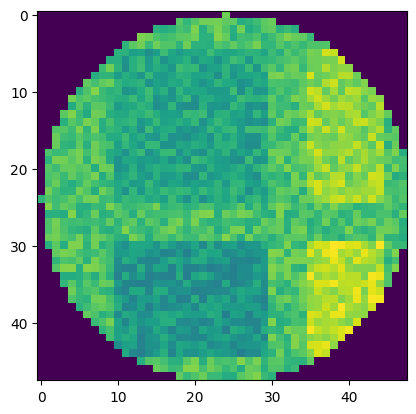

In [1]:
import numpy as np

state_shape = (48, 48)

# define space
space = np.ones(state_shape)

# add artifacts
space[5:25, 10:30] = 0.8
space[5:25, 35:45] = 1.2
space[30:45, 10:30] = 0.7
space[30:45, 35:45] = 1.3

# add random nosie
space += np.random.random(state_shape) / 3

# space limitations: ellipse
x_coords, y_coords = np.meshgrid(np.arange(state_shape[0]), np.arange(state_shape[1]), indexing='ij')
a, b = state_shape[0] // 2, state_shape[1] // 2
space[((x_coords - a) / a) ** 2 + ((y_coords - b)  / b) ** 2 > 1] = 0

# show space
import matplotlib.pyplot as plt

plt.imshow(space)

## Generate data

In [2]:
from physicslearn.equations.fisher_kolmogorov import FisherKolmogorovEq
from physicslearn.equations.wrappers.basic import ClipStateWrapper, LimitSpaceWrapper, ScaleWrapper
from physicslearn.utils.initialstategenerators import gaussian_distribution_initial_states
from physicslearn.utils.datagenerator import generate_data

# define equation and wrapp it
eq = FisherKolmogorovEq()
eq = LimitSpaceWrapper(eq, space)
eq = ClipStateWrapper(eq, 0.0, 1.0)
eq = ScaleWrapper(eq, 255)

n_examples = 60

parameters = np.ones((n_examples, 2))
parameters[:, 0] = np.random.random((n_examples,)) * 0.1 + 0.5
parameters[:, 1] = np.random.random((n_examples,)) * 0.1 + 0.7

# generate data
initial_states = gaussian_distribution_initial_states(state_shape, n_examples, 5, 0.2)
data = generate_data(eq, parameters, (0, 2048, 64), initial_states)

train_data = data[:48]
test_data = data[48:]

train_data.shape

(48, 32, 48, 48)

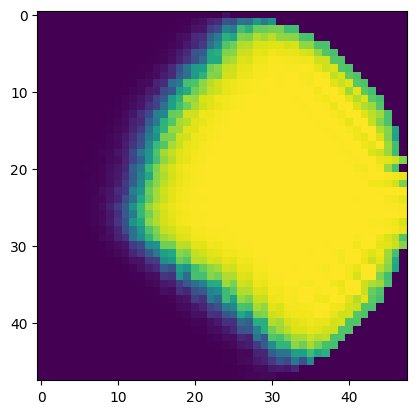

In [3]:
# sample state
plt.imshow(data[15, 30])

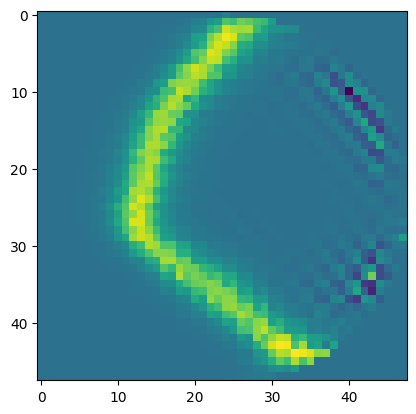

In [4]:
# aim: change of state
plt.imshow(data[15, 30] - data[15, 29])

# Model

In [5]:
import torch as th

from physicslearn.nn.pinn.ae_pinn import PhysicsInformedAutoEncoder
from physicslearn.nn.common.conv import ConvNetworkConfig
from physicslearn.nn.common.dense import DenseNetworkConfig

encoder_conv_config = ConvNetworkConfig(
    channels=[1, 32, 16],
    kernel_sizes=[5, 3]
)

enoder_dense_config = DenseNetworkConfig(
    layer_sizes=[512, 128, 64]
)

parameter_inference = DenseNetworkConfig(
    layer_sizes=[128, 128, 2]
)

pinn = PhysicsInformedAutoEncoder(state_shape, encoder_conv_config, enoder_dense_config, parameter_inference)

_du_dt, _params = pinn(th.ones((1, 1, *state_shape)), th.ones((1, 1)))
print(_du_dt.shape)
print(_params.shape)

torch.Size([1, 1, 48, 48])
torch.Size([1, 2])


# Training

## Equation with space without noise and artifacts

In [6]:
space[space > 0] = 1

train_eq = FisherKolmogorovEq()
train_eq = LimitSpaceWrapper(train_eq, space)
train_eq = ClipStateWrapper(train_eq, 0.0, 1.0)
train_eq = ScaleWrapper(train_eq, 255)

## First, learn parameter inference

In [7]:
from physicslearn.nn.pinn.trainer import PINNTrainer, PINNLoss

pinn_loss = PINNLoss(train_eq, 0.1, 0.1, 1.3)

# add channel dimension
data_tensor = th.Tensor(data)[:, :, None, :, :]

trainer = PINNTrainer(data_tensor, pinn_loss, batch_size=64, train_ratio=0.6)

pinn = trainer.fit(pinn, 0.0005, epochs=5)

Epoch 1
-------------------------------
    1/18: PINN train loss: 0.7108254432678223
    2/18: PINN train loss: 0.6835265159606934
    3/18: PINN train loss: 0.6833773851394653
    4/18: PINN train loss: 0.7126438021659851
    5/18: PINN train loss: 0.7458511590957642
    6/18: PINN train loss: 0.453666090965271
    7/18: PINN train loss: 0.7447039484977722
    8/18: PINN train loss: 0.6595340967178345
    9/18: PINN train loss: 1.0073564052581787
    10/18: PINN train loss: 0.8550912737846375
    11/18: PINN train loss: 0.8852944374084473
    12/18: PINN train loss: 0.7337967157363892
    13/18: PINN train loss: 0.7723793983459473
    14/18: PINN train loss: 0.7387415170669556
    15/18: PINN train loss: 0.8778113126754761
    16/18: PINN train loss: 1.1617456674575806
    17/18: PINN train loss: 0.7223509550094604
    18/18: PINN train loss: 1.3154430389404297
    PINN test loss: 0.6519678235054016
Epoch 2
-------------------------------
    1/18: PINN train loss: 0.8843321800231934

## Then, learn du/dt to be similar to the product of equation

In [8]:
pinn_loss = PINNLoss(train_eq, 1.0, 0.1, 0.4)

trainer = PINNTrainer(data_tensor, pinn_loss, batch_size=64, train_ratio=0.6)

pinn = trainer.fit(pinn, 0.0005, epochs=5)

Epoch 1
-------------------------------
    1/18: PINN train loss: 3.812526226043701
    2/18: PINN train loss: 2.4540762901306152
    3/18: PINN train loss: 3.085115909576416
    4/18: PINN train loss: 3.8686113357543945
    5/18: PINN train loss: 2.971482038497925
    6/18: PINN train loss: 3.533007860183716
    7/18: PINN train loss: 2.5780954360961914
    8/18: PINN train loss: 3.860055923461914
    9/18: PINN train loss: 3.9466323852539062
    10/18: PINN train loss: 4.6292195320129395
    11/18: PINN train loss: 4.139331340789795
    12/18: PINN train loss: 3.731523036956787
    13/18: PINN train loss: 3.769071578979492
    14/18: PINN train loss: 2.9391188621520996
    15/18: PINN train loss: 5.8242506980896
    16/18: PINN train loss: 4.0366997718811035
    17/18: PINN train loss: 4.964181423187256
    18/18: PINN train loss: 6.6379876136779785
    PINN test loss: 3.565007448196411
Epoch 2
-------------------------------
    1/18: PINN train loss: 4.954676151275635
    2/18: PI

## On the finish, try to fit to the real data

In [9]:
pinn_loss = PINNLoss(train_eq, 0.5, 0.5, 0.5)

trainer = PINNTrainer(data_tensor, pinn_loss, batch_size=64, train_ratio=0.6)

pinn = trainer.fit(pinn, 0.0005, epochs=5)

Epoch 1
-------------------------------
    1/18: PINN train loss: 3.0416064262390137
    2/18: PINN train loss: 1.8636367321014404
    3/18: PINN train loss: 3.7181429862976074
    4/18: PINN train loss: 2.917686939239502
    5/18: PINN train loss: 3.143167495727539
    6/18: PINN train loss: 2.790105104446411
    7/18: PINN train loss: 4.79832649230957
    8/18: PINN train loss: 3.8420162200927734
    9/18: PINN train loss: 2.6475536823272705
    10/18: PINN train loss: 3.8694357872009277
    11/18: PINN train loss: 3.4387292861938477
    12/18: PINN train loss: 2.7061548233032227
    13/18: PINN train loss: 4.455528259277344
    14/18: PINN train loss: 3.3536500930786133
    15/18: PINN train loss: 2.8391878604888916
    16/18: PINN train loss: 4.06636905670166
    17/18: PINN train loss: 2.706120491027832
    18/18: PINN train loss: 5.348613739013672
    PINN test loss: 3.5537776947021484
Epoch 2
-------------------------------
    1/18: PINN train loss: 2.3478689193725586
    2/18

## Test

tensor([[0.0000, 3.1688]])
tensor([[0.0000, 1.2551]])
tensor([[0.0000, 0.9423]])
tensor([[0.7574, 0.8034]])
tensor([[0.0000, 1.9154]])
tensor([[0.4337, 1.0405]])
tensor([[0.0000, 2.1174]])
tensor([[0.0000, 0.7963]])
tensor([[0.0000, 2.1524]])
tensor([[0.2098, 0.6851]])
tensor([[0.0000, 1.2333]])
tensor([[0.2072, 1.2191]])


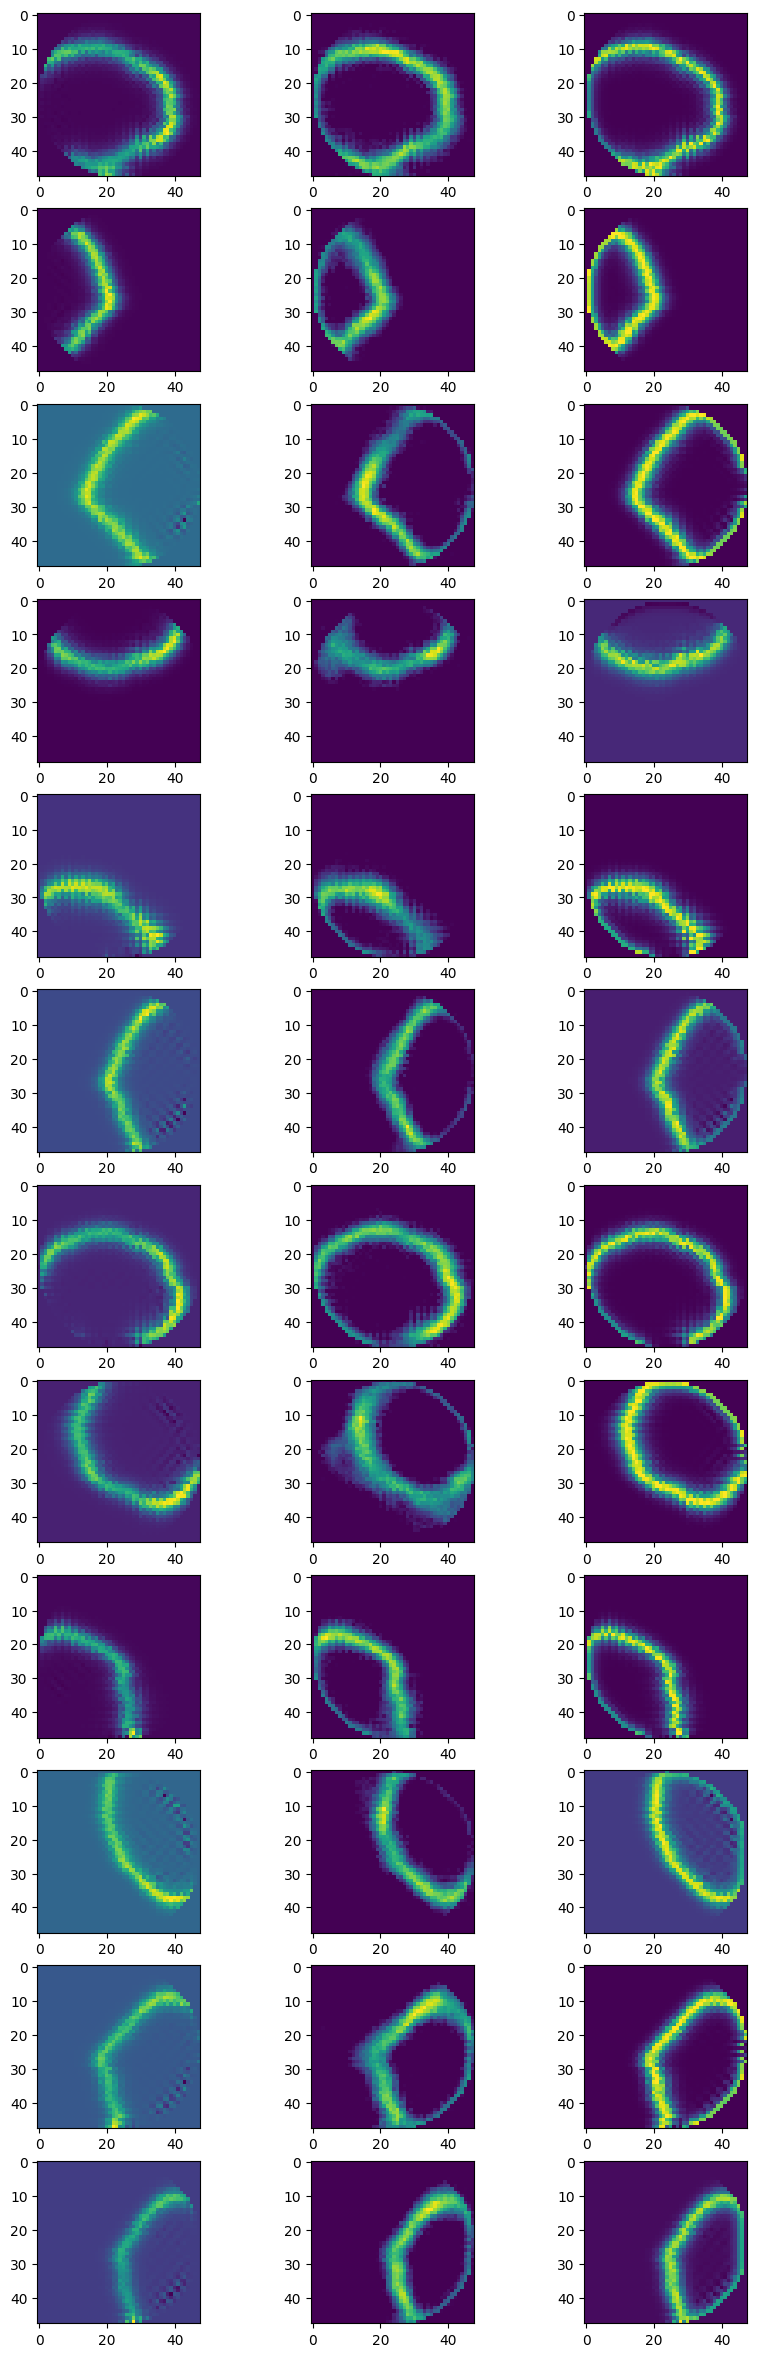

In [13]:
test_data_tensor = th.Tensor(test_data)[:, :, None, :, :]


def show_results(test_data, t):
    _, axs = plt.subplots(len(test_data), 3, figsize=(10, 30))
    with th.no_grad():
        for i, state in enumerate(test_data[:, t]):
            axs[i, 0].imshow(test_data[i, t+1] - state)
            prediction, parameters = pinn(test_data_tensor[i, t:t+1], th.ones((1, 1)) * t)
            print(parameters)
            axs[i, 1].imshow(prediction[0, 0])
            axs[i, 2].imshow(train_eq(test_data_tensor[i, t:t+1][0], np.ones((1,1)) * t, parameters)[0])


show_results(test_data, 30)

tensor([[0.0000, 1.9532]])
tensor([[0.1300, 2.4356]])
tensor([[0.7152, 1.4172]])
tensor([[0.1947, 0.6874]])
tensor([[0.0000, 1.2076]])
tensor([[0.4484, 0.3272]])
tensor([[0.0000, 1.8378]])
tensor([[1.1056, 2.0344]])
tensor([[0.0000, 2.2998]])
tensor([[0.6108, 0.7615]])
tensor([[0.0000, 0.8349]])
tensor([[0.0000, 0.5425]])


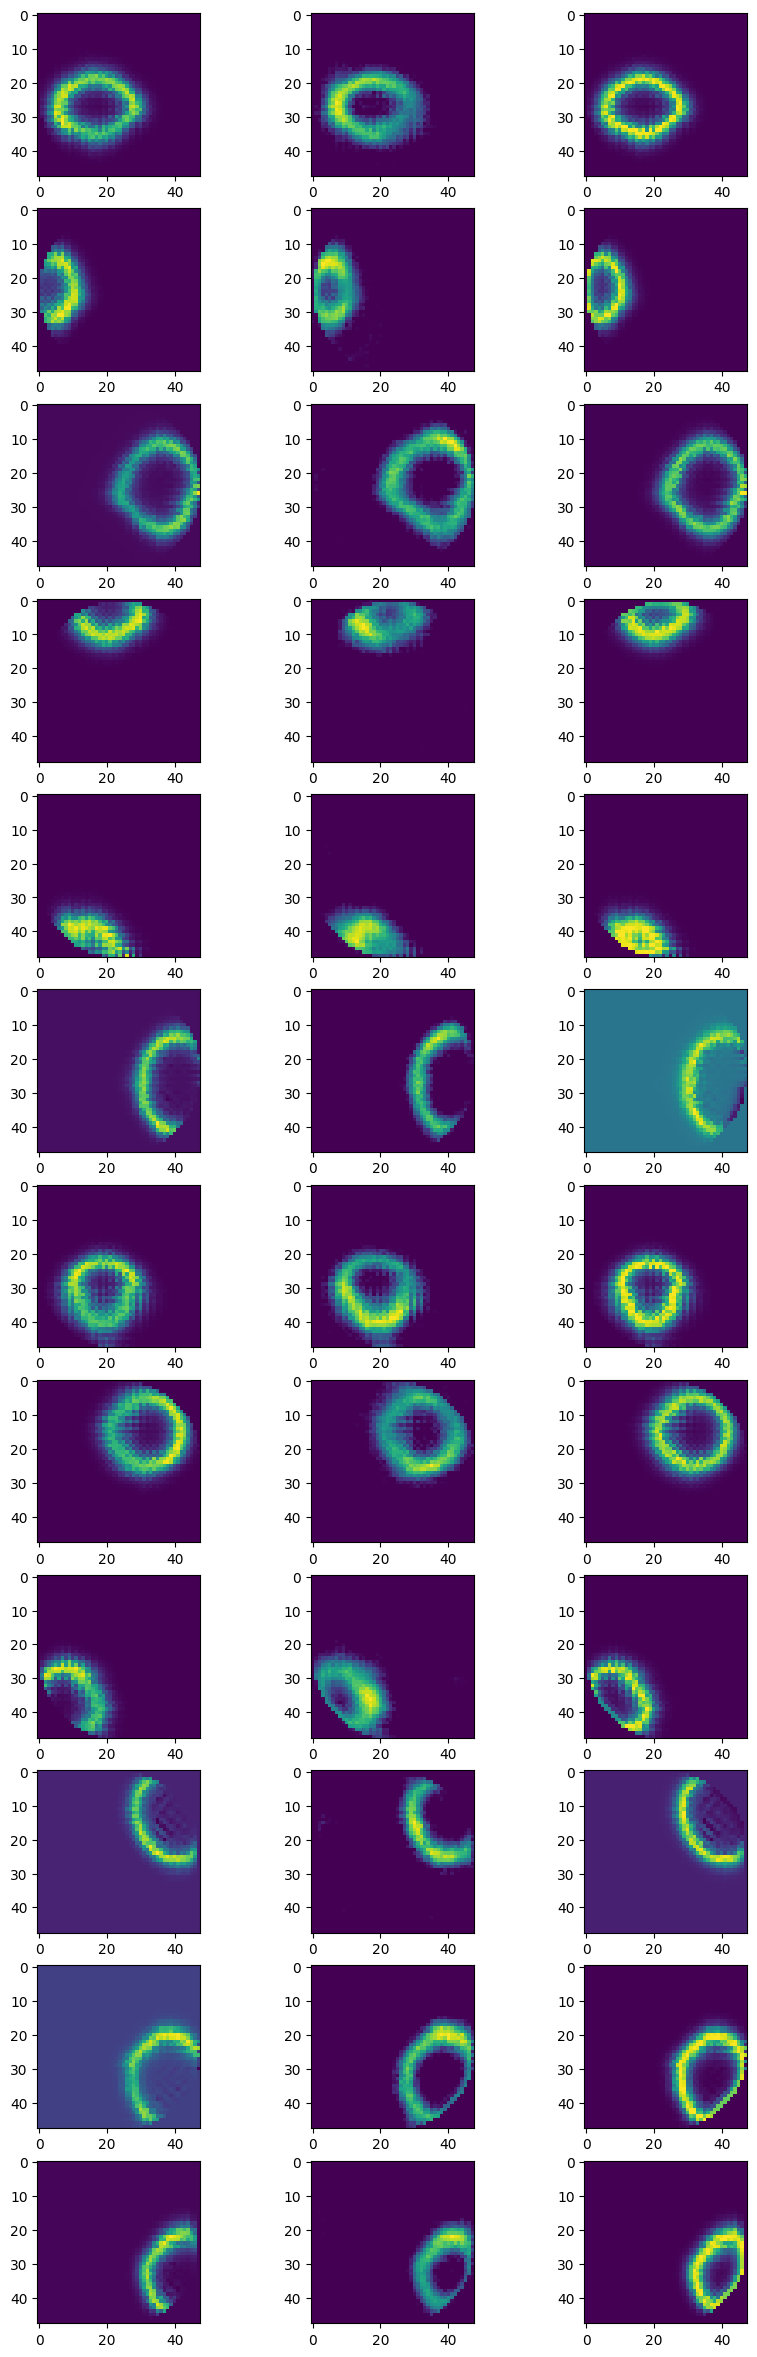

In [14]:
show_results(test_data, 20)

tensor([[0.0000, 0.6868]])
tensor([[0.0000, 0.7135]])
tensor([[0.0000, 0.5882]])
tensor([[0.0000, 0.7137]])
tensor([[0.0000, 0.6952]])
tensor([[0.0000, 0.6759]])
tensor([[0.0000, 0.6587]])
tensor([[0.0000, 0.6116]])
tensor([[0.0000, 0.7720]])
tensor([[0.1915, 0.7639]])
tensor([[0.0000, 0.7179]])
tensor([[0.0000, 0.6823]])


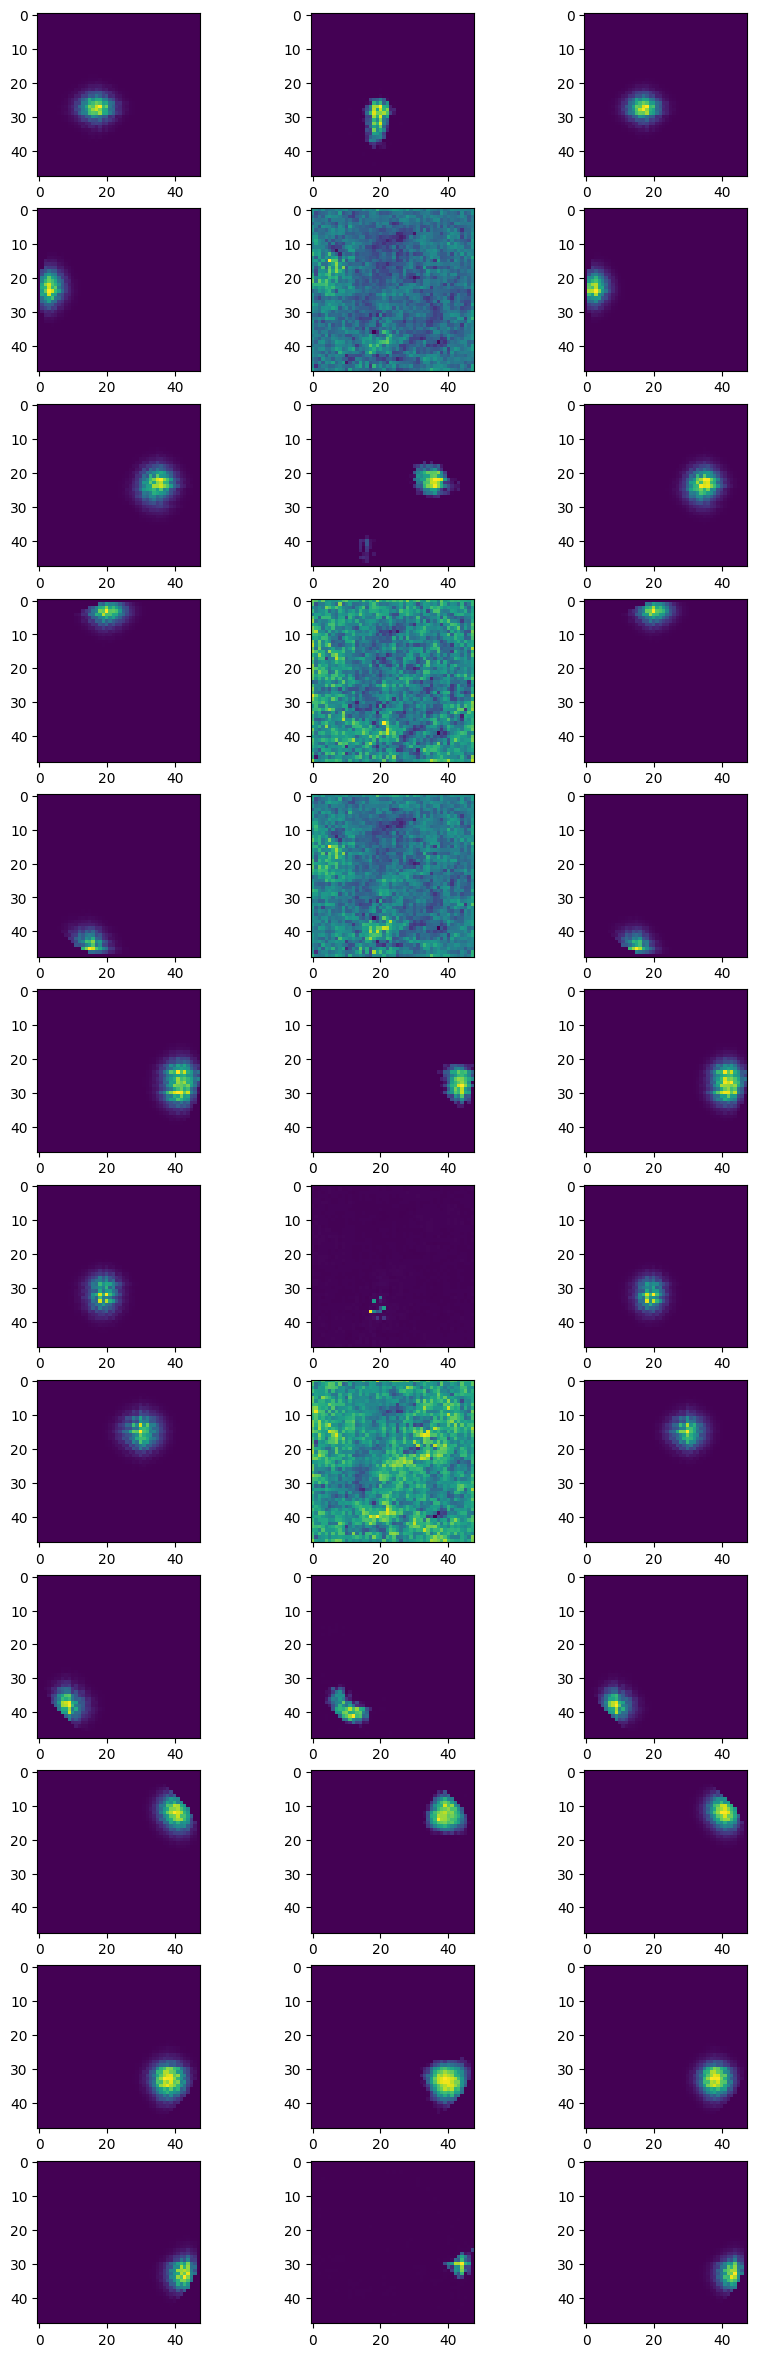

In [15]:
show_results(test_data, 10)